In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mahmoud-dataset/README
/kaggle/input/mahmoud-dataset/dataset_description.json
/kaggle/input/mahmoud-dataset/participants.json
/kaggle/input/mahmoud-dataset/participants.tsv
/kaggle/input/mahmoud-dataset/CHANGES
/kaggle/input/mahmoud-dataset/sub-654178/sub-654178_scans.tsv
/kaggle/input/mahmoud-dataset/sub-654178/sub-654178_scans.json
/kaggle/input/mahmoud-dataset/sub-654178/anat/sub-654178_acq-headmotion1_T1w.json
/kaggle/input/mahmoud-dataset/sub-654178/anat/sub-654178_acq-standard_T1w.json
/kaggle/input/mahmoud-dataset/sub-654178/anat/sub-654178_acq-headmotion2_T1w.json
/kaggle/input/mahmoud-dataset/sub-654178/anat/sub-654178_acq-headmotion1_T1w.nii/sub-654178_ses-1_acq-move1_T1w.nii
/kaggle/input/mahmoud-dataset/sub-654178/anat/sub-654178_acq-headmotion2_T1w.nii/sub-654178_ses-1_acq-move2_T1w.nii
/kaggle/input/mahmoud-dataset/sub-654178/anat/sub-654178_acq-standard_T1w.nii/sub-654178_ses-1_acq-conve_T1w.nii
/kaggle/input/mahmoud-dataset/sub-228373/sub-228373_scans.tsv


In [47]:
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import exposure
import os
import subprocess

In [48]:
class data_loader():
    def __init__(self,data_path,split_ratio):
        ''' 
            this function take the path of whole data {Movement-related artefacts (MR-ART) dataset}
            data_path : path for this data
            split_ratio : list of ratios for train,test,validation
        '''
        self.data_path = data_path 
        self.split_ratio = split_ratio # ratios to split the data with train,test,validation [in form of list]
        self.all_subjects = None # list contain all subject in the path 
        self.subjects_lists = [] # list of subjects for train,test,validation [in form of list]
        self.labels = {'train':0,'test':1,'validation':2} 
        self.size = [0,0,0] #size of data train,test,validation  [in form of list]
    def list_subjects(self):
        ''' 
        this function list all subjects in the data
        no parameters
        '''
        subjects = os.listdir(self.data_path)
        subjects = [item for item in subjects if item.startswith('sub')]
        self.all_subjects = subjects
    def get_nifti_path(self, subject,number_of_motion='1'):
        ref_path_stand = f'{self.data_path}/{subject}/anat/{subject}_acq-standard_T1w.nii/'
        select_path_stand = subprocess.run(['ls', ref_path_stand], capture_output=True, text=True).stdout.replace("\n", "")

        ref_path_motion = f'{self.data_path}/{subject}/anat/{subject}_acq-headmotion{number_of_motion}_T1w.nii/'
        select_path_motion = subprocess.run(['ls', ref_path_motion], capture_output=True, text=True).stdout.replace("\n", "")

        return [ref_path_stand+select_path_stand, ref_path_motion+select_path_motion]
    def get_paired_volumes(self,path):
        '''
        this function return nifti volume of free subject and motion subject and normalize them between [0,1]
        path: list of paths of free subject and motion subject
        '''
        if os.path.exists(path[0]) and os.path.exists(path[1]) :
            free_data = nib.load(path[0]).get_fdata() # read free volume
#             for channel in range(free_data.shape[0]):
#                 free_data[channel, :, :] = exposure.rescale_intensity(free_data[channel, :, :], out_range=(0.0, 1.0))
            free_data = exposure.rescale_intensity(free_data, out_range=(0.0,1.0)) # normalize over volume [0,1]
            motion_data = nib.load(path[1]).get_fdata()
#             for channel in range(motion_data.shape[0]):
#                 motion_data[channel, :, :] = exposure.rescale_intensity(motion_data[channel, :, :], out_range=(0.0, 1.0))
            motion_data = exposure.rescale_intensity(motion_data, out_range=(0.0,1.0))
#             free_data = free_data[27:-27]
#             motion_data = motion_data[27:-27]
            return free_data,motion_data
        else:
            return None,None #
    def split_data(self):
        self.list_subjects()
        if sum(self.split_ratio) == 1 and len(self.split_ratio)<=3:
            self.split_ratio.insert(0,0)
            cumulative_sum = [sum(self.split_ratio[:i+1]) for i in range(len(self.split_ratio))]
            number_of_subjects = len(self.all_subjects)
            for i in range(1,len(self.split_ratio)):
                self.subjects_lists.append(self.all_subjects[int(round(cumulative_sum[i-1]*number_of_subjects)):int(round(cumulative_sum[i]*number_of_subjects))])
                self.size[i-1] = len(self.subjects_lists[i-1])*380
                if i-1 == 0:
                    self.size[i-1] -= 8*380
        else:
            print("The Summation of ratios not equal 1")
    def generator(self,select_subjects,batch_size):
        # self.split_data()
        subjects = self.subjects_lists[self.labels[select_subjects]]
        while True:
            for subject in subjects:
                for i in range(2):
                    pathes = self.get_nifti_path(subject,str(i+1))
                    free,motion = self.get_paired_volumes(pathes)
                    if motion is not None:
                        number_of_batches = int(motion.shape[0]//batch_size)
                        for batch in range(number_of_batches):
                            free_batch = free[batch*batch_size+1:(batch+1)*batch_size+1]
                            free_batch = np.expand_dims(free_batch, axis=-1)
#                             print(free_batch.shape)
#                             free_batch = exposure.rescale_intensity(free_batch, out_range=(-1.0,1.0))
                            motion_batch = motion[batch*batch_size+1:(batch+1)*batch_size+1]
                            motion_batch = np.expand_dims(motion_batch, axis=-1)
#                             motion_batch = exposure.rescale_intensity(motion_batch, out_range=(-1.0,1.0))
                            motion_before_batch = motion[batch*batch_size:(batch+1)*batch_size]
                            motion_before_batch = np.expand_dims(motion_before_batch, axis=-1)
#                             motion_before_batch = exposure.rescale_intensity(motion_before_batch, out_range=(-1.0,1.0))
                            motion_after_batch = motion[batch*batch_size+2:(batch+1)*batch_size+2]
                            motion_after_batch = np.expand_dims(motion_after_batch, axis=-1)
#                             motion_after_batch = exposure.rescale_intensity(motion_after_batch, out_range=(-1.0,1.0))
                            yield [motion_before_batch,motion_batch,motion_after_batch],free_batch

In [49]:
import keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import numpy as np

IMAGE_ORDERING_CHANNELS_LAST = "channels_last"
IMAGE_ORDERING_CHANNELS_FIRST = "channels_first"

# Default IMAGE_ORDERING = channels_last
IMAGE_ORDERING = IMAGE_ORDERING_CHANNELS_LAST

if IMAGE_ORDERING == 'channels_first':
	MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
	MERGE_AXIS = -1

# CBAM --------------------------------------------
# Convolutional Block Attention Module(CBAM) block
def cbam_block(cbam_feature, ratio=32):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=32):

	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]  # input_feature._keras_shape[channel_axis]

	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

	avg_pool = GlobalAveragePooling2D()(input_feature)
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)

	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)

	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7

	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature

	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

def UNet(img_input):
	k1 = 32
	k2 = 64
	k3 = 128
	k4 = 256
	# Block 1 in Contracting Path
	conv1 = Conv2D(k1, (3, 3), data_format=IMAGE_ORDERING,padding='same', dilation_rate=1)(img_input)
	conv1 = BatchNormalization()(conv1)
	conv1 = Activation('relu')(conv1)
# 	conv1 = Dropout(0.2)(conv1)
	conv1 = Conv2D(k1, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(conv1)
	conv1 = BatchNormalization()(conv1)
	conv1 = Activation('relu')(conv1)

	conv1 = cbam_block(conv1)   # Convolutional Block Attention Module(CBAM) block
    
	o = Conv2D(k1, (2, 2), strides=(2, 2), data_format=IMAGE_ORDERING)(conv1)
	o = BatchNormalization()(o)
	o = Activation('relu')(o)
# 	o = AveragePooling2D((2, 2), strides=(2, 2))(conv1)
# 	o = MaxPooling2D((2, 2), strides=(2, 2))(conv1)

	# Block 2 in Contracting Path
	conv2 = Conv2D(k2, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(o)
	conv2 = BatchNormalization()(conv2)
	conv2 = Activation('relu')(conv2)
# 	conv2 = Dropout(0.2)(conv2)
	conv2 = Conv2D(k2, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(conv2)
	conv2 = BatchNormalization()(conv2)
	conv2 = Activation('relu')(conv2)

	conv2 = cbam_block(conv2)  # Convolutional Block Attention Module(CBAM) block
    
	o = Conv2D(k2, (2, 2), strides=(2, 2), data_format=IMAGE_ORDERING)(conv2)
	o = BatchNormalization()(o)
	o = Activation('relu')(o)
# 	o = AveragePooling2D((2, 2), strides=(2, 2))(conv2)
# 	o = MaxPooling2D((2, 2), strides=(2, 2))(conv2)

	# Block 3 in Contracting Path
	conv3 = Conv2D(k3, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(o)
	conv3 = BatchNormalization()(conv3)
	conv3 = Activation('relu')(conv3)
# 	conv3 = Dropout(0.2)(conv3)
	conv3 = Conv2D(k3, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(conv3)
	conv3 = BatchNormalization()(conv3)
	conv3 = Activation('relu')(conv3)

	conv3 = cbam_block(conv3) # Convolutional Block Attention Module(CBAM) block
    
	o = Conv2D(k3, (2, 2), strides=(2, 2), data_format=IMAGE_ORDERING)(conv3)
	o = BatchNormalization()(o)
	o = Activation('relu')(o)
    
# 	o = MaxPooling2D((2, 2), strides=(2, 2))(conv3)
# 	o = AveragePooling2D((2, 2), strides=(2, 2))(conv3)

	 # Transition layer between contracting and expansive paths:
	conv4 = Conv2D(k4, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(o)
	conv4 = BatchNormalization()(conv4)
	conv4 = Activation('relu')(conv4)
# 	conv4 = Dropout(0.2)(conv4)
	conv4 = Conv2D(k4, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(conv4)
	conv4 = BatchNormalization()(conv4)
	conv4 =Activation('relu')(conv4)

	conv4 = cbam_block(conv4)    # Convolutional Block Attention Module(CBAM) block


	# Block 1 in Expansive Path
	up1 = UpSampling2D((2, 2), data_format=IMAGE_ORDERING)(conv4)
	up1 = concatenate([up1, conv3], axis=MERGE_AXIS)
	deconv1 =  Conv2D(k3, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(up1)
	deconv1 = BatchNormalization()(deconv1)
	deconv1 = Activation('relu')(deconv1)
# 	deconv1 = Dropout(0.2)(deconv1)
	deconv1 =  Conv2D(k3, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(deconv1)
	deconv1 = BatchNormalization()(deconv1)
	deconv1 = Activation('relu')(deconv1)

	deconv1 = cbam_block(deconv1)    # Convolutional Block Attention Module(CBAM) block

	# Block 2 in Expansive Path
	up2 = UpSampling2D((2, 2), data_format=IMAGE_ORDERING)(deconv1)
	up2 = concatenate([up2, conv2], axis=MERGE_AXIS)
	deconv2 = Conv2D(k2, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(up2)
	deconv2 = BatchNormalization()(deconv2)
	deconv2 = Activation('relu')(deconv2)
# 	deconv2 = Dropout(0.2)(deconv2)
	deconv2 = Conv2D(k2, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(deconv2)
	deconv2 = BatchNormalization()(deconv2)
	deconv2 = Activation('relu')(deconv2)

	deconv2 = cbam_block(deconv2)    # Convolutional Block Attention Module(CBAM) block

	# Block 3 in Expansive Path
	up3 = UpSampling2D((2, 2), data_format=IMAGE_ORDERING)(deconv2)
	up3 = concatenate([up3, conv1], axis=MERGE_AXIS)
	deconv3 = Conv2D(k1, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(up3)
	deconv3 = BatchNormalization()(deconv3)
	deconv3 = Activation('relu')(deconv3)
# 	deconv3 = Dropout(0.2)(deconv3)
	deconv3 = Conv2D(k1, (3, 3), data_format=IMAGE_ORDERING, padding='same', dilation_rate=1)(deconv3)
	deconv3 = BatchNormalization()(deconv3)
	deconv3 = Activation('relu')(deconv3)

	deconv3 = cbam_block(deconv3)    # Convolutional Block Attention Module(CBAM) block
	output = Conv2D(1, (3, 3), data_format=IMAGE_ORDERING, padding='same')(deconv3)
    
	output = Activation('sigmoid')(output)
	return output

def Correction_Multi_input(input_height, input_width):
	assert input_height % 32 == 0
	assert input_width % 32 == 0

#   UNET
	img_input_1 = Input(shape=(input_height, input_width, 1))
	img_input_2 = Input(shape=(input_height, input_width, 1))
	img_input_3 = Input(shape=(input_height, input_width, 1))
	kk = 128
	conv1 = Conv2D(kk, (3, 3), data_format=IMAGE_ORDERING,padding='same', dilation_rate=1)(img_input_1) # dilation_rate=6
	conv1 = BatchNormalization()(conv1)
	conv1 = Activation('relu')(conv1)
	conv2 = Conv2D(kk, (3, 3), data_format=IMAGE_ORDERING,padding='same', dilation_rate=1)(img_input_2) # dilation_rate=6
	conv2 = BatchNormalization()(conv2)
	conv2 = Activation('relu')(conv2)
	conv3 = Conv2D(kk, (3, 3), data_format=IMAGE_ORDERING,padding='same', dilation_rate=1)(img_input_3) # dilation_rate=6
	conv3 = BatchNormalization()(conv3)
	conv3 = Activation('relu')(conv3)     
	input_concat = concatenate([conv1, conv2, conv3], axis=MERGE_AXIS)  #conv4
	# dataset = tf.data.Dataset.from_tensor_slices((img_input_1, img_input_2, img_input_3)

	## Two Stacked Nets:
	pred_1  = UNet(input_concat)
	input_2 = concatenate([input_concat, pred_1], axis=MERGE_AXIS)
	pred_2  = UNet(input_2) #

	model = Model(inputs=[img_input_1,img_input_2,img_input_3], outputs=pred_2)


	return model

In [ ]:
import numpy as np
from tensorflow.keras import backend as K
import scipy.io
import tensorflow as tf
from tensorflow.keras.optimizers import  Adam,AdamW
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import math
import pandas as pd
# from read_data import read_data
# from Correction_Multi_input import Correction_Multi_input
from tensorflow.keras.models import model_from_json
import cv2
import os
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

# -------------------------------------------------------
Train = 1 # True False
Test  = 1 # True False
# -------------------------------------------------------
nb_epoch      = 14
learningRate  = 0.01 # 0.001
optimizer     = Adam(learning_rate=learningRate)
batch_size    = 15
Height        = 256     # input image dimensions
Width         = 256
Prediction_path  = '/kaggle/working//Prediction'
Weights_path     = '/kaggle/working//Weights'

def save_model(path_weight, model, md='lstm'):
    model_json = model.to_json()
    with open(path_weight + "model_" + md + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(path_weight + "model_" + md + ".h5")
    print("The model is successfully saved")

def load_model(path_weight, md='lstm', custom_objects=None):
    json_file = open(path_weight + "model_" + md + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json, custom_objects=custom_objects)
    loaded_model.load_weights(path_weight + "model_" + md + ".h5")
    print("Loaded model from disk")
    return loaded_model

def ssim_score(y_true, y_pred):
	score = K.mean(tf.image.ssim(y_true, y_pred, 1.0))
	return score

def ssim_loss(y_true, y_pred):
	#loss_ssim = 1.0 - K.mean((tf.image.ssim(y_true, y_pred, 255.0)+1.0)/2.0)## SSIM range is between -1~1 so --> +1/2 is added
	#loss_ssim = 1.0 - K.mean(tf.image.ssim(y_true, y_pred, 255.0))
	loss_ssim = 1.0 - K.mean(tf.image.ssim(y_true, y_pred, 1.0))
	return loss_ssim


def scheduler(epoch):
	ep = 10
	if epoch < ep:
		return learningRate
	else:
		return learningRate * math.exp(0.1 * (ep - epoch)) # lr decreases exponentially by a factor of 10
# -------------------------------------------------------
def main():
	print('Reading Data ... ')
	path = '/kaggle/input/mahmoud-dataset'
	Data_loader = data_loader(path,[0.8,0.15,0.05])
	Data_loader.split_data()
	# train_data, train_label, valid_data, valid_label, test_data, test_label, fold2_train_before, fold3_valid_before, fold1_test_before, fold2_train_after, fold3_valid_after, fold1_test_after = read_data(train_data_path,train_GT_path,valid_data_path,valid_GT_path,test_data_path,test_GT_path)
	print('---------------------------------')
	# print('Trainingdata=',train_data.shape)
	# print('Traininglabel=',train_label.shape)
	# print('valid_data=',valid_data.shape)
	# print('valid_label=',valid_label.shape)
	# print('test_data=',test_data.shape)
	# print('test_label=',test_label.shape)
	print('---------------------------------')

	if Train:
		print('---------------------------------')
		print('Model Training ...')
		print('---------------------------------')
		model = Correction_Multi_input(Height, Width)
# 		print(model.summary())
		csv_logger = CSVLogger(Weights_path+'Loss_Acc.csv', append=True, separator=',')
		reduce_lr = LearningRateScheduler(scheduler)
		model.compile(loss=ssim_loss, optimizer=optimizer, metrics=[ssim_score,'mse'])
		checkpoint_path = '/kaggle/working/stacked_model_LR&ff128_{epoch:02d}_val_loss_{val_loss:.4f}.h5'
		model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=False,
                                   save_weights_only=False,
                                   mode='min',
                                   verbose=1)
# 		model.load_weights('/kaggle/working/model_41k_epoch_03_val_loss_130.8155.h5')
		hist = model.fit(
      	Data_loader.generator('train',batch_size),
						steps_per_epoch=Data_loader.size[0]//batch_size,
# 						steps_per_epoch= 9,         
						epochs = nb_epoch, #100,
						verbose = 1,          # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
						validation_data=Data_loader.generator('test',batch_size),
						validation_steps=Data_loader.size[1]//batch_size,
# 						validation_steps=2,            
# 						initial_epoch=3,# test_CE
						callbacks=[csv_logger, reduce_lr,model_checkpoint])
		model.save('/kaggle/working//stacked_model.h5')
		print("Saved H5")
		# Save the training history to a CSV file
		hist_df = pd.DataFrame(hist.history)
		hist_df.to_csv('/kaggle/working//training_history.csv', index=False)
		print("Saved Csv of loss")
		print('Saving Model...')
		save_model(Weights_path, model,'CorrectionUNet_') # to save the weight - 'CNN_iter_'+str(i)

	if Test:
		# Load the model
		print('========================================Load Model-s Weights=====================================')
		# model = load_model(Weights_path, 'CorrectionUNet_')
		#  # to load the weight
		custom_objects = {'ssim_loss': ssim_loss, 'ssim_score': ssim_score}

		# Load the model
		model = load_model(path_weight=Weights_path, md='lstm', custom_objects=custom_objects)
		print('---------------------------------')
		print('Evaluate Model on Testing Set ...')
		print('---------------------------------')
		#pred = model.predict(test_data)
		pred = model.predict(Data_loader.generator('validation',batch_size),steps=Data_loader.size[2]//batch_size)  # test_CE
		print('==================================')
		print('Predictions=',pred.shape)
		print('==================================')

		# To save reconstructed data:
		# inps = sorted(glob.glob(os.path.join(test_data_path, "*.png")))
		# assert type(inps) is list
		# for i, inp in enumerate(inps):
		# 	out_fname = os.path.join(Prediction_path, os.path.basename(inp))
		# 	out_img = pred[i,:,:,:]
		# 	cv2.imwrite(out_fname, out_img)
main()

Reading Data ... 
---------------------------------
---------------------------------
---------------------------------
Model Training ...
---------------------------------
Epoch 1/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1919 - ssim_score: 0.8081 - mse: 0.0042
Epoch 1: saving model to /kaggle/working/stacked_model_LR&ff128_01_val_loss_0.1937.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2220s 782ms/step - loss: 0.1919 - ssim_score: 0.8081 - mse: 0.0042 - val_loss: 0.1937 - val_ssim_score: 0.8063 - val_mse: 0.0094 - lr: 0.0100
Epoch 2/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1754 - ssim_score: 0.8246 - mse: 0.0027
Epoch 2: saving model to /kaggle/working/stacked_model_LR&ff128_02_val_loss_0.1609.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2174s 780ms/step - loss: 0.1754 - ssim_score: 0.8246 - mse: 0.0027 - val_loss: 0.1609 - val_ssim_score: 0.8391 - val_mse: 0.0024 - lr: 0.0100
Epoch 3/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1711 - ssim_score: 0.8289 - mse: 0.0025
Epoch 3: saving model to /kaggle/working/stacked_model_LR&ff128_03_val_loss_0.1678.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2174s 780ms/step - loss: 0.1711 - ssim_score: 0.8289 - mse: 0.0025 - val_loss: 0.1678 - val_ssim_score: 0.8322 - val_mse: 0.0020 - lr: 0.0100
Epoch 4/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1700 - ssim_score: 0.8300 - mse: 0.0025
Epoch 4: saving model to /kaggle/working/stacked_model_LR&ff128_04_val_loss_0.1972.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2174s 780ms/step - loss: 0.1700 - ssim_score: 0.8300 - mse: 0.0025 - val_loss: 0.1972 - val_ssim_score: 0.8028 - val_mse: 0.0021 - lr: 0.0100
Epoch 5/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1689 - ssim_score: 0.8311 - mse: 0.0025
Epoch 5: saving model to /kaggle/working/stacked_model_LR&ff128_05_val_loss_0.2332.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2173s 780ms/step - loss: 0.1689 - ssim_score: 0.8311 - mse: 0.0025 - val_loss: 0.2332 - val_ssim_score: 0.7668 - val_mse: 0.0064 - lr: 0.0100
Epoch 6/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1670 - ssim_score: 0.8330 - mse: 0.0024
Epoch 6: saving model to /kaggle/working/stacked_model_LR&ff128_06_val_loss_0.1776.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2172s 780ms/step - loss: 0.1670 - ssim_score: 0.8330 - mse: 0.0024 - val_loss: 0.1776 - val_ssim_score: 0.8224 - val_mse: 0.0021 - lr: 0.0100
Epoch 7/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1667 - ssim_score: 0.8333 - mse: 0.0024
Epoch 7: saving model to /kaggle/working/stacked_model_LR&ff128_07_val_loss_0.2630.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2172s 780ms/step - loss: 0.1667 - ssim_score: 0.8333 - mse: 0.0024 - val_loss: 0.2630 - val_ssim_score: 0.7370 - val_mse: 0.0086 - lr: 0.0100
Epoch 8/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1684 - ssim_score: 0.8316 - mse: 0.0025
Epoch 8: saving model to /kaggle/working/stacked_model_LR&ff128_08_val_loss_0.1790.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2172s 780ms/step - loss: 0.1684 - ssim_score: 0.8316 - mse: 0.0025 - val_loss: 0.1790 - val_ssim_score: 0.8210 - val_mse: 0.0026 - lr: 0.0100
Epoch 9/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1669 - ssim_score: 0.8331 - mse: 0.0024
Epoch 9: saving model to /kaggle/working/stacked_model_LR&ff128_09_val_loss_0.2161.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2171s 779ms/step - loss: 0.1669 - ssim_score: 0.8331 - mse: 0.0024 - val_loss: 0.2161 - val_ssim_score: 0.7839 - val_mse: 0.0042 - lr: 0.0100
Epoch 10/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1664 - ssim_score: 0.8336 - mse: 0.0024
Epoch 10: saving model to /kaggle/working/stacked_model_LR&ff128_10_val_loss_0.2446.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2172s 780ms/step - loss: 0.1664 - ssim_score: 0.8336 - mse: 0.0024 - val_loss: 0.2446 - val_ssim_score: 0.7554 - val_mse: 0.0060 - lr: 0.0100
Epoch 11/14
2786/2786 [==============================] - ETA: 0s - loss: 0.1652 - ssim_score: 0.8348 - mse: 0.0023
Epoch 11: saving model to /kaggle/working/stacked_model_LR&ff128_11_val_loss_0.1909.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2786/2786 [==============================] - 2173s 780ms/step - loss: 0.1652 - ssim_score: 0.8348 - mse: 0.0023 - val_loss: 0.1909 - val_ssim_score: 0.8091 - val_mse: 0.0035 - lr: 0.0100
Epoch 12/14
1579/2786 [================>.............] - ETA: 14:53 - loss: 0.1683 - ssim_score: 0.8317 - mse: 0.0024

In [35]:
def sample_reshape(sample):
  sample = sample.reshape(1,sample.shape[0],sample.shape[1])
  return sample
def plot_samples(volumes,model_path,number_of_samples,norm=True):
  angle = 90
  subs= np.random.randint(0, len(volumes), number_of_samples)
  samples = np.random.randint(27,165, number_of_samples)
  model = load_model(model_path,
                     custom_objects={'ssim_loss': ssim_loss, 'ssim_score': ssim_score,"K":K})
  for i in range(number_of_samples):
      path = '/kaggle/input/mahmoud-dataset'
      ref_path_free = f'{path}/{volumes[subs[i]]}/anat/{volumes[subs[i]]}_acq-standard_T1w.nii/'
      select_path_free = subprocess.run(['ls', ref_path_free], capture_output=True, text=True).stdout.replace("\n", "")
      ref_path_motion = f'{path}/{volumes[subs[i]]}/anat/{volumes[subs[i]]}_acq-headmotion1_T1w.nii/'
      select_path_motion = subprocess.run(['ls', ref_path_motion], capture_output=True, text=True).stdout.replace("\n", "")
      motion_vol = nib.load(ref_path_motion+select_path_motion).get_fdata()
      free_vol = nib.load(ref_path_free+select_path_free).get_fdata()
      free_vol = free_vol.astype(np.float32)
      motion_vol = motion_vol.astype(np.float32)
      if norm:
        motion_vol = exposure.rescale_intensity(motion_vol, out_range=(0.0,1.0))
        free_vol = exposure.rescale_intensity(free_vol, out_range=(0.0,1.0))
      else:
        motion_vol = exposure.rescale_intensity(motion_vol, out_range=(-1.0,1.0))
        free_vol = exposure.rescale_intensity(free_vol, out_range=(-1.0,1.0))
      pred_image = model.predict([sample_reshape(motion_vol[samples[i]-1]),sample_reshape(motion_vol[samples[i]]),sample_reshape(motion_vol[samples[i]+1])])
      # Fix the subplot call
      plt.figure(figsize=(8, 30))
      # Plot Image 1
      rotated_motion = ndimage.rotate(motion_vol[samples[i]], angle)
      plt.subplot(number_of_samples, 3, i * 3 + 1)
      plt.imshow(rotated_motion, cmap='gray')
      plt.title('Motion Image')
      plt.axis('off')
      # print(f'motion max value :- {sample_motion[0].max()}')
      # Plot Image 2
      rotated_free = ndimage.rotate(free_vol[samples[i]], angle)
      plt.subplot(number_of_samples, 3, i * 3 + 2)
      plt.imshow(rotated_free, cmap='gray')
      plt.title('Free Image')
      plt.axis('off')
      # print(f'free max value :- {sample_motion[0].max()}')
      # Plot Image 3
      rotated_pred = ndimage.rotate(pred_image[0], angle)
      plt.subplot(number_of_samples, 3, i * 3 + 3)
      plt.imshow(rotated_pred, cmap='gray')
      plt.title('Model Image')
      plt.axis('off')
      # print(f'predicted max value :- {pred_image[0].max()}')
      plt.tight_layout()
#       plt.savefig(f'/content/drive/MyDrive/Plots/plot_{i+1}.png')
  # Adjust layout and display the plot
  plt.show()

1/1 [==============================] - 0s 54ms/step


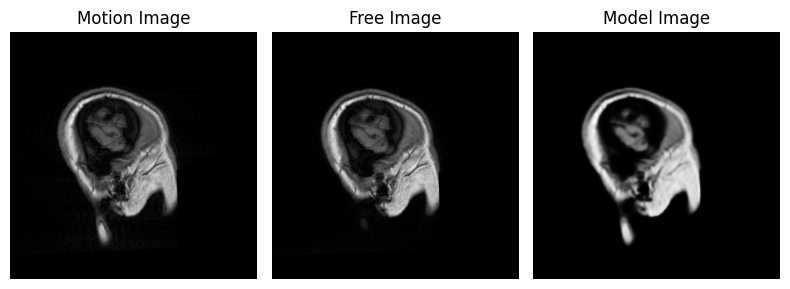

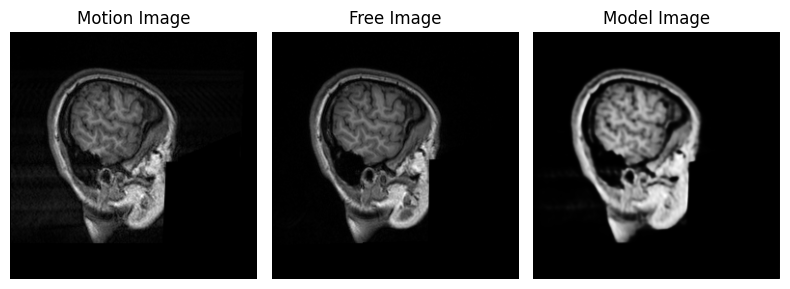

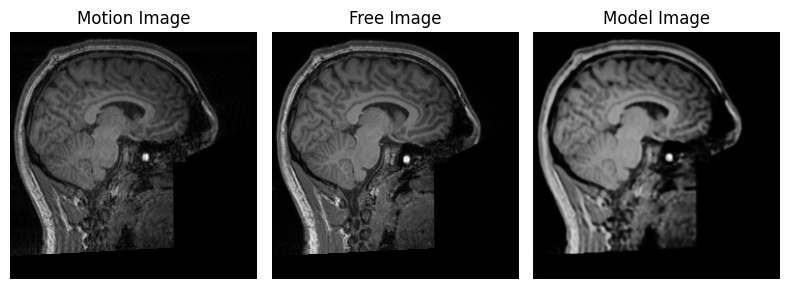

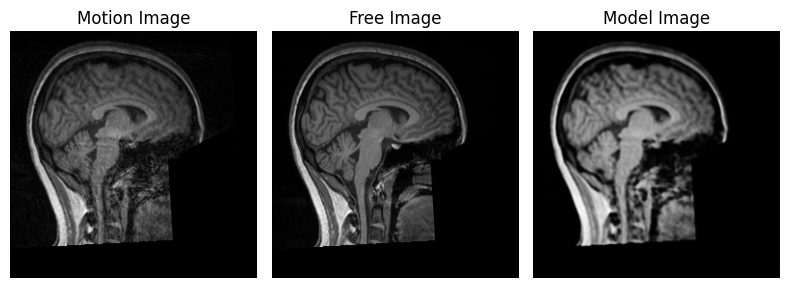

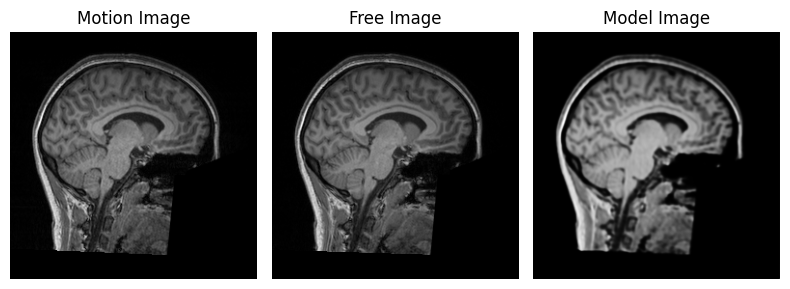

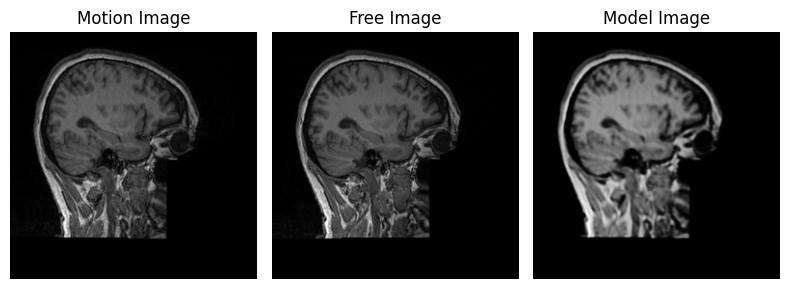

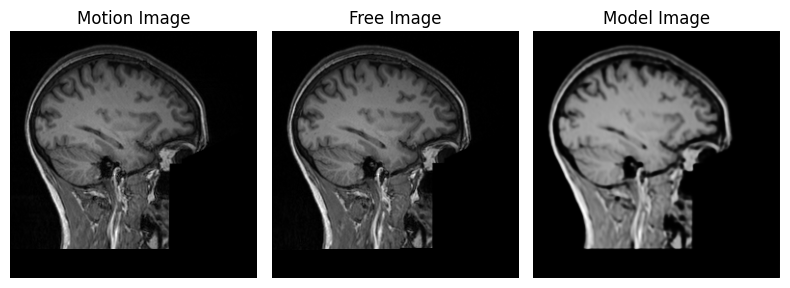

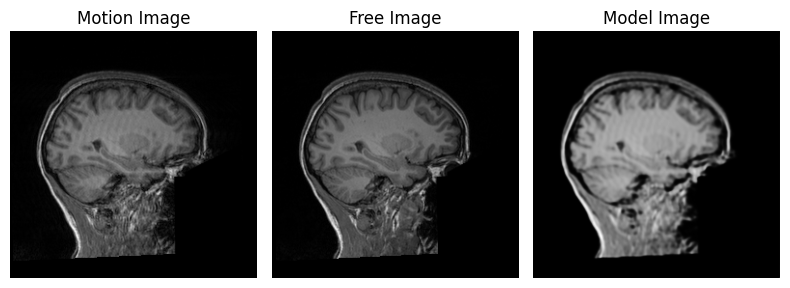

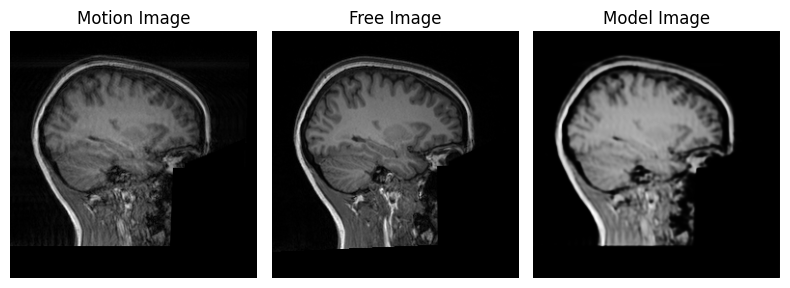

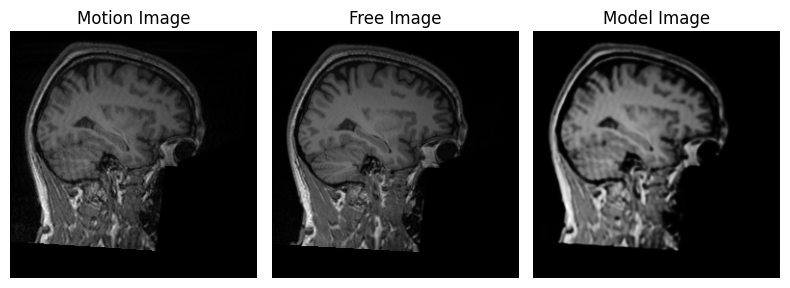

In [37]:
from tensorflow.keras.models import load_model
from scipy import ndimage
volumes = os.listdir('/kaggle/input/mahmoud-dataset')
volumes = [item for item in volumes if item.startswith('sub')]
plot_samples(volumes,'/kaggle/working/stacked_model_tanh_02_val_loss_0.1832.h5',10,norm=False)